## REFIT Dataset

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = (25, 15)

In [3]:
path="/Users/daniel.bustillo/Documents/thesis/REFIT"
os.chdir(path)

In [6]:
list_of_names= []
list_of_names=os.listdir(path)



In [116]:
  
# create empty list
dataframes_list = []
  
# append datasets into teh list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv(list_of_names[i], parse_dates=True, index_col=0, infer_datetime_format=True)
    dataframes_list.append(temp_df)

In [117]:
dataframes_list = [df.resample("1H").mean() for df in dataframes_list]
dataframes_list = [df.drop(['Unix','Issues'], axis=1) for df in dataframes_list]

Text(0.5, 1.0, 'House 12')

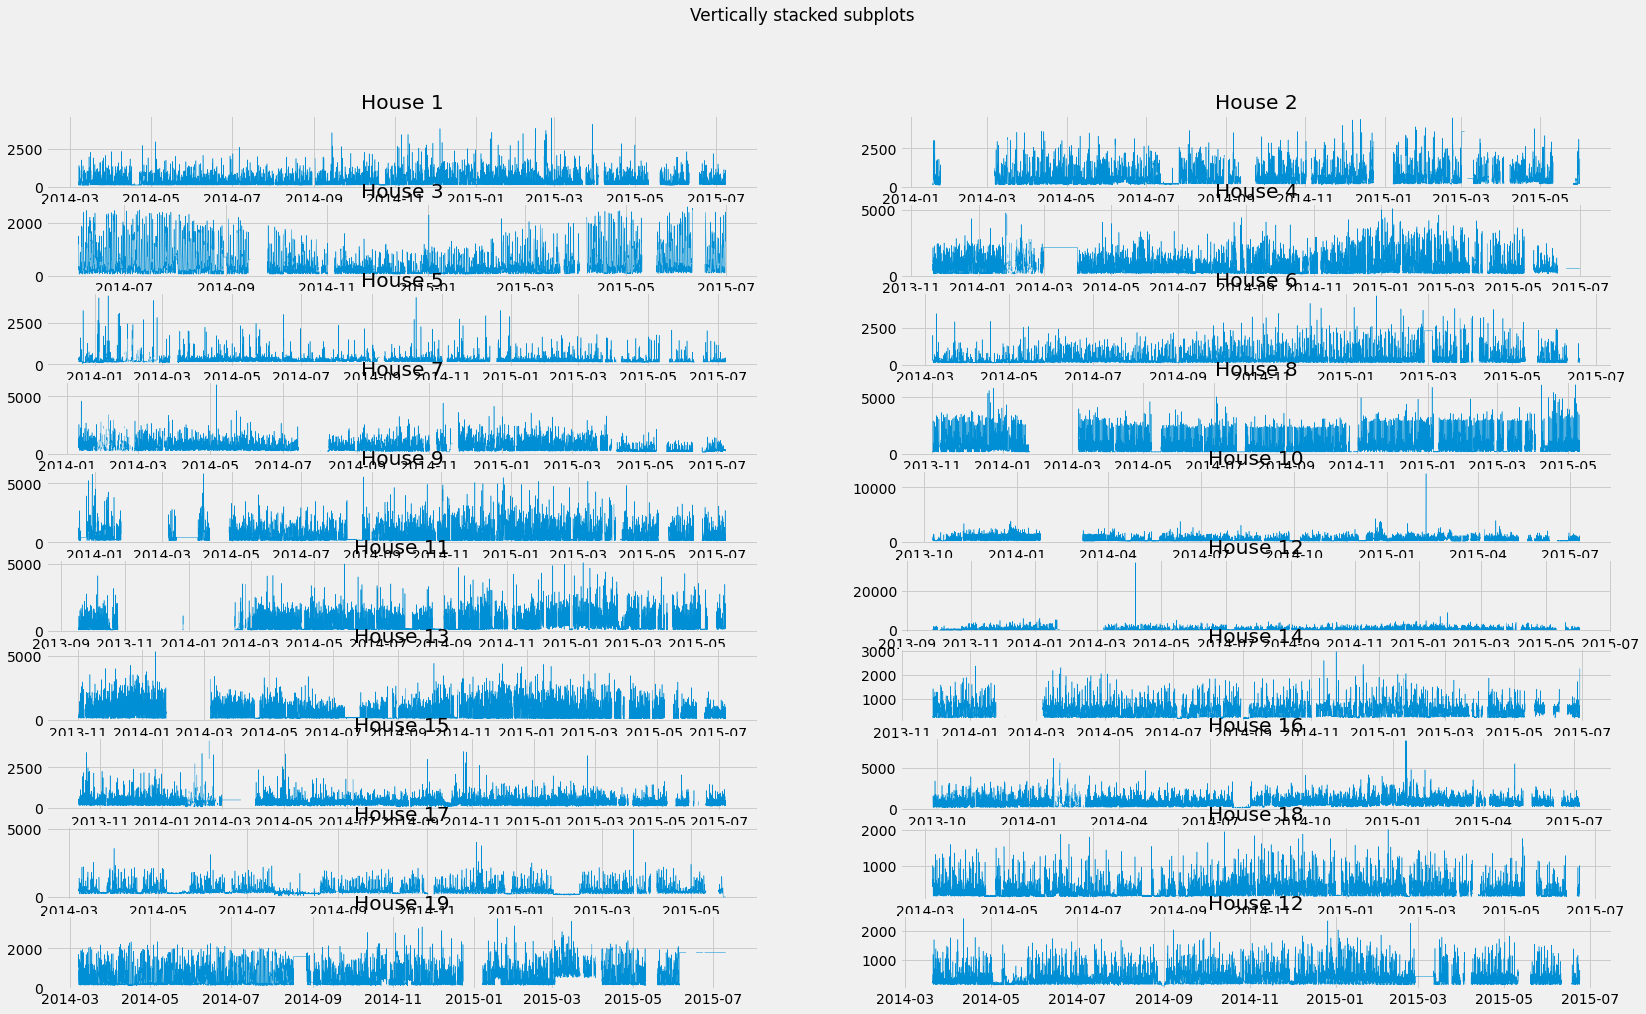

In [26]:
fig, axs = plt.subplots(10,2)
fig.suptitle('Vertically stacked subplots')
axs[0,0].plot(dataframes_list[0]['Aggregate'], lw=0.5)
axs[0,0].set_title("House 1")
axs[0,1].plot(dataframes_list[1]['Aggregate'], lw=0.5)
axs[0,1].set_title("House 2")
axs[1,0].plot(dataframes_list[2]['Aggregate'], lw=0.5)
axs[1,0].set_title("House 3")
axs[1,1].plot(dataframes_list[3]['Aggregate'], lw=0.5)
axs[1,1].set_title("House 4")
axs[2,0].plot(dataframes_list[4]['Aggregate'], lw=0.5)
axs[2,0].set_title("House 5")
axs[2,1].plot(dataframes_list[5]['Aggregate'], lw=0.5)
axs[2,1].set_title("House 6")
axs[3,0].plot(dataframes_list[6]['Aggregate'], lw=0.5)
axs[3,0].set_title("House 7")
axs[3,1].plot(dataframes_list[7]['Aggregate'], lw=0.5)
axs[3,1].set_title("House 8")
axs[4,0].plot(dataframes_list[8]['Aggregate'], lw=0.5)
axs[4,0].set_title("House 9")
axs[4,1].plot(dataframes_list[9]['Aggregate'], lw=0.5)
axs[4,1].set_title("House 10")
axs[5,0].plot(dataframes_list[10]['Aggregate'], lw=0.5)
axs[5,0].set_title("House 11")
axs[5,1].plot(dataframes_list[11]['Aggregate'], lw=0.5)
axs[5,1].set_title("House 12")
axs[6,0].plot(dataframes_list[12]['Aggregate'], lw=0.5)
axs[6,0].set_title("House 13")
axs[6,1].plot(dataframes_list[13]['Aggregate'], lw=0.5)
axs[6,1].set_title("House 14")
axs[7,0].plot(dataframes_list[14]['Aggregate'], lw=0.5)
axs[7,0].set_title("House 15")
axs[7,1].plot(dataframes_list[15]['Aggregate'], lw=0.5)
axs[7,1].set_title("House 16")
axs[8,0].plot(dataframes_list[16]['Aggregate'], lw=0.5)
axs[8,0].set_title("House 17")
axs[8,1].plot(dataframes_list[17]['Aggregate'], lw=0.5)
axs[8,1].set_title("House 18")
axs[9,0].plot(dataframes_list[18]['Aggregate'], lw=0.5)
axs[9,0].set_title("House 19")
axs[9,1].plot(dataframes_list[19]['Aggregate'], lw=0.5)
axs[9,1].set_title("House 12")



In [45]:
dataframes_list[0].loc[(dataframes_list[0].index>"2014-07-01")&(dataframes_list[0].index<="2014-07-02")].plot(lw=1)

AttributeError: 'NoneType' object has no attribute 'loc'

In [118]:
def create_features(df):
    """
    Creates time series features from datetime index.
    """
    # df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night']= np.where((df['hour']>=18)|(df['hour']<6),1,0)

In [119]:
[create_features(df) for df in dataframes_list]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [98]:
import seaborn as sns

<AxesSubplot:ylabel='Time'>

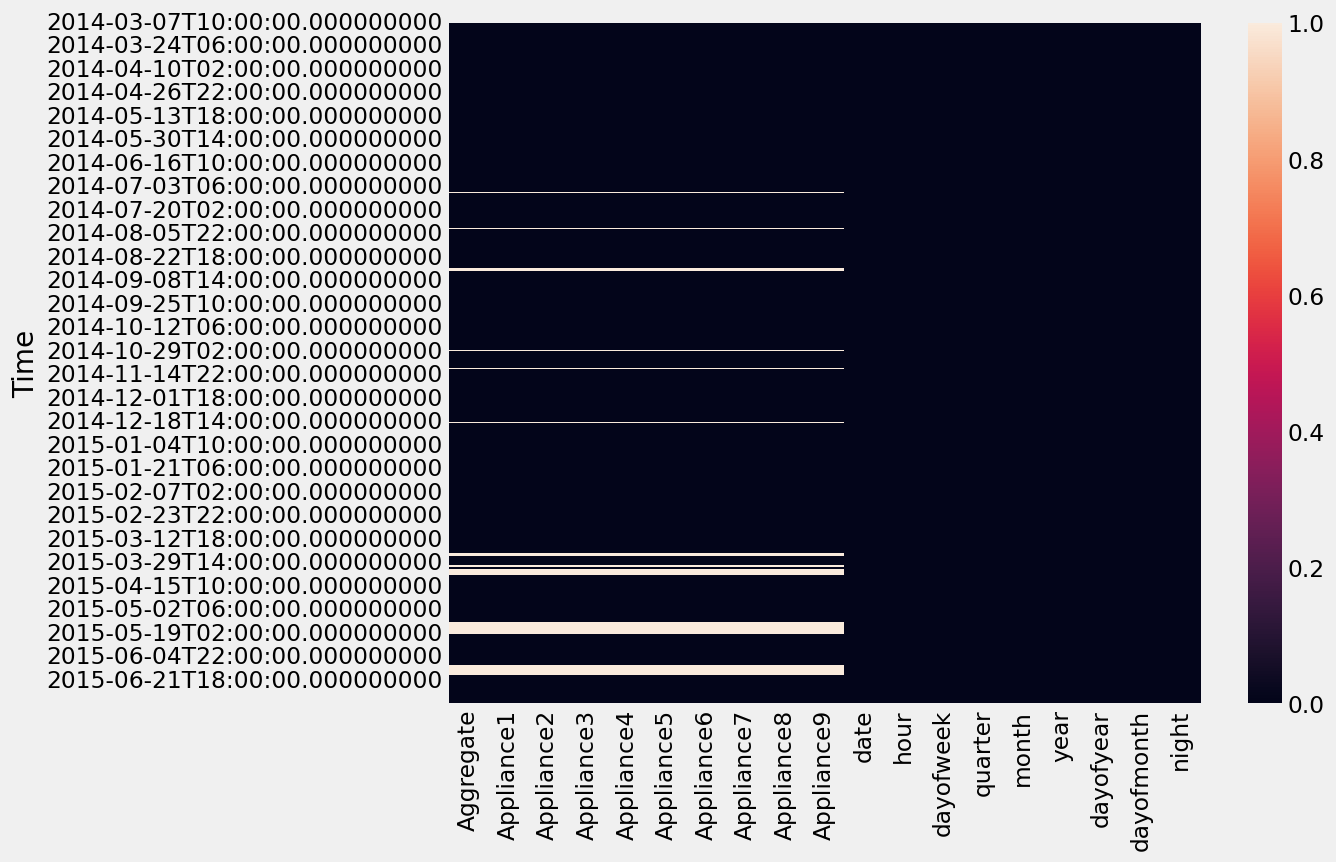

In [120]:
sns.heatmap(dataframes_list[0].isna())

In [123]:
#Missing data on all datasets

dataframes_list[0].fillna(method='ffill', axis=0, inplace=True)

In [151]:
#Transform the data
from scipy import stats
bc_fitted_feature, bc_fitted_lambda = stats.boxcox(dataframes_list[0]['Aggregate']+1) # Again, we are adding 1 because all features have 0s (not allowed in BC)

bc_fitted_lambda

-0.8797148760104455

In [152]:
dataframes_list[0]['Agg_transformed'] = bc_fitted_feature

<AxesSubplot:xlabel='Time'>

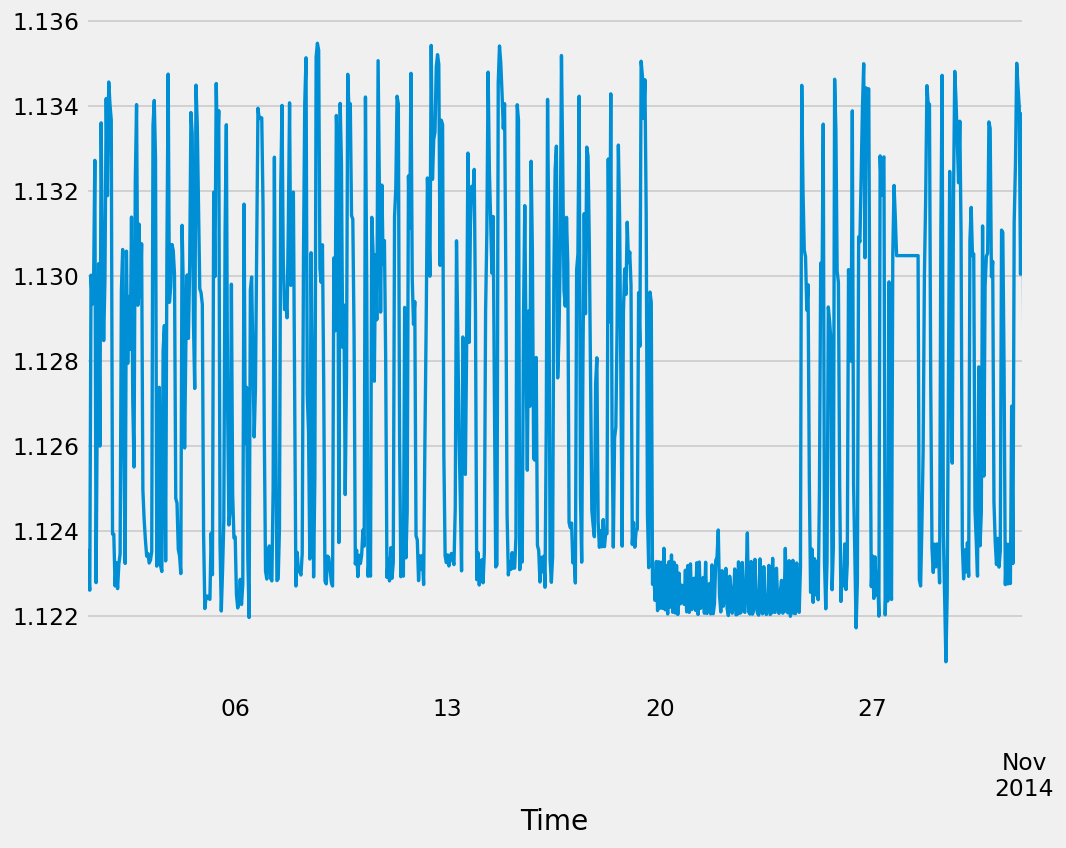

In [158]:
dataframes_list[0]['Agg_transformed'].loc[(dataframes_list[0].index>"2014-10-01")&(dataframes_list[0].index<="2014-11-01")].plot(lw=2)

In [126]:
#ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [160]:
#Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(dataframes_list[0]['Agg_transformed'].dropna(),autolag="AIC")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.951448
p-value: 0.000000


In [161]:
#Time Series split
from sklearn.model_selection import TimeSeriesSplit
tscv= TimeSeriesSplit(n_splits=15,max_train_size=780)

In [162]:
X= pd.Series(dataframes_list[0]["Agg_transformed"].values)
X

0        1.129658
1        1.129805
2        1.121940
3        1.123439
4        1.122052
           ...   
11700    1.131198
11701    1.124752
11702    1.123899
11703    1.124126
11704    1.124255
Length: 11705, dtype: float64

In [84]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.model_selection import train_test_split

In [164]:
X_train, X_test = train_test_split(X, train_size=0.8, shuffle=False)

In [165]:
X_train = pd.Series(X_train)
X_train

0       1.129658
1       1.129805
2       1.121940
3       1.123439
4       1.122052
          ...   
9359    1.123276
9360    1.123276
9361    1.123276
9362    1.123276
9363    1.123276
Length: 9364, dtype: float64

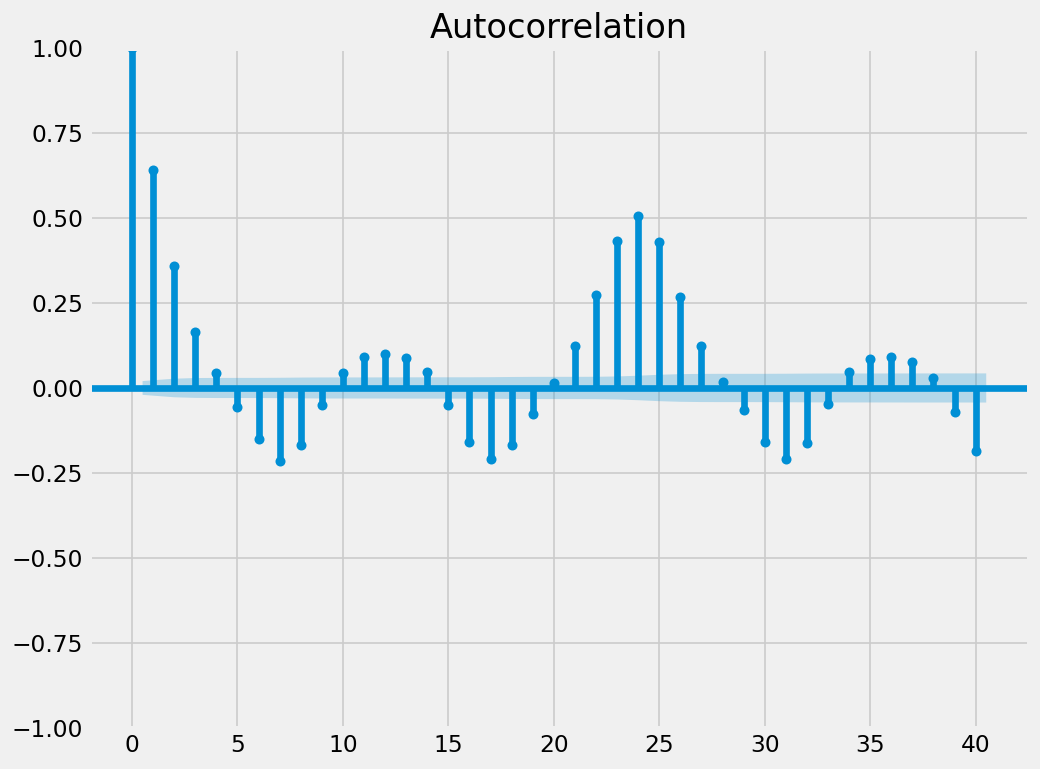

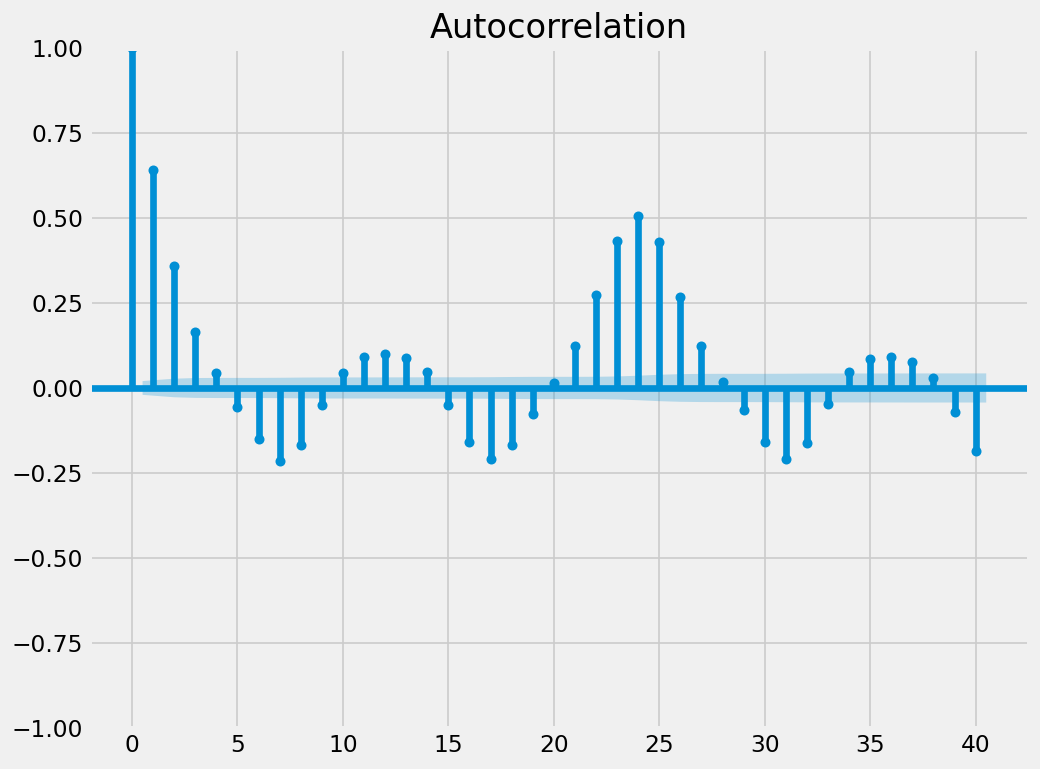

In [166]:
plot_acf(X_train)


In [167]:
model= pm.auto_arima(X_train, seasonal=True, suppress_warnings=True)


In [170]:

preds, conf_int = model.predict(n_periods=X_test.shape[0], return_conf_int=True)

In [172]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9364
Model:               SARIMAX(2, 1, 4)   Log Likelihood               40250.047
Date:                Thu, 03 Mar 2022   AIC                         -80486.095
Time:                        18:37:19   BIC                         -80436.083
Sample:                             0   HQIC                        -80469.111
                               - 9364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4993      1.196      0.417      0.676      -1.845       2.844
ar.L2          0.0197      0.675      0.029      0.977      -1.302       1.342
ma.L1         -0.7559      1.196     -0.632      0.528      -3.101       1.589
ma.L2         -0.1279      0.982     -0.130      0.896      -2.052       1.796
ma.L3         -0.0746      0.111     -0.671      0.502      -0.292       0.143
ma.L4         -0.0172      0.081     -0.213      0.831      -0.176       0.141
sigma2      1.079e-05   1.95e-07     55.490      0.000    1.04e-05    1.12e-05
===================================================================================
Ljung-Box (L1) (Q):                  17.07   Jarque-Bera (JB):               443.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    


[ 320.85483871  328.61245675  138.13884007  156.10606061  139.35185185
  163.66331658  176.08658009  162.96367521 1418.65892857  350.1957672
  401.89212329  263.69860627  152.12878788  175.82490975  160.87341772
  135.87114338  131.84162063  143.26775956  143.1261426   131.40699816
  154.96428571 1068.54166667 1272.56672761  529.65280289  140.26691042
  263.44144144  234.12363636  218.00544465  546.15699659  140.09563758
  310.55387205  219.64655172  547.43133803  345.37659963  444.36
  310.26666667  256.26545455  144.14673913  157.25840708  140.03085299
  127.99267399  136.84909091  138.37892791  127.42115028  339.0749543
 1043.04136691 1086.82817869  728.38018018  318.44262295  306.76311031
  867.37163375 1784.13309353  858.42980936  907.99643494  271.16420664
  267.75719424  325.06118881  338.11484099  294.73083779  286.05820106
  196.3540146   136.25090909  131.6024735   137.39927405  139.14981949
  135.28228782  131.6101083   140.93967093  370.61001789  324.70178571
  145.09821429

In [173]:
#Prophet

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [175]:
dataframes_list[0]['Agg_transformed']

Time
2014-03-07 10:00:00    1.129658
2014-03-07 11:00:00    1.129805
2014-03-07 12:00:00    1.121940
2014-03-07 13:00:00    1.123439
2014-03-07 14:00:00    1.122052
                         ...   
2015-07-07 22:00:00    1.131198
2015-07-07 23:00:00    1.124752
2015-07-08 00:00:00    1.123899
2015-07-08 01:00:00    1.124126
2015-07-08 02:00:00    1.124255
Freq: H, Name: Agg_transformed, Length: 11705, dtype: float64

In [182]:
X = dataframes_list[0]

In [183]:
X_train, X_test = train_test_split(X, test_size=0.1, shuffle=False)

In [184]:
X_train['ds']= X_train.index
X_test['ds'] = X_test.index

X_train = X_train[['ds','Agg_transformed']]
X_test = X_test[['ds','Agg_transformed']]

/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_67757/2259697320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ds']= X_train.index
/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_67757/2259697320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ds'] = X_test.index


In [188]:
# Format data for prophet model using ds and y
X_train =X_train.reset_index()
X_train= X_train[['ds','Agg_transformed']]
X_train =X_train.rename(columns={"Agg_transformed":"y"})


In [193]:
model= Prophet(interval_width=0.95,yearly_seasonality=False, weekly_seasonality=True,daily_seasonality=True)
model.fit(X_train)

Initial log joint probability = -2.14227


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56180.8   0.000450998       14647.4        0.53        0.53      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       56201.3   0.000492814       3501.14           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       56211.1    0.00013198       10232.5           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       56221.5   1.90669e-06       2740.34      0.3105      0.3105      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       56233.4   8.44491e-05       6847.05      0.6656      0.6656      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599    

In [194]:
prediction = model.predict(X_test)

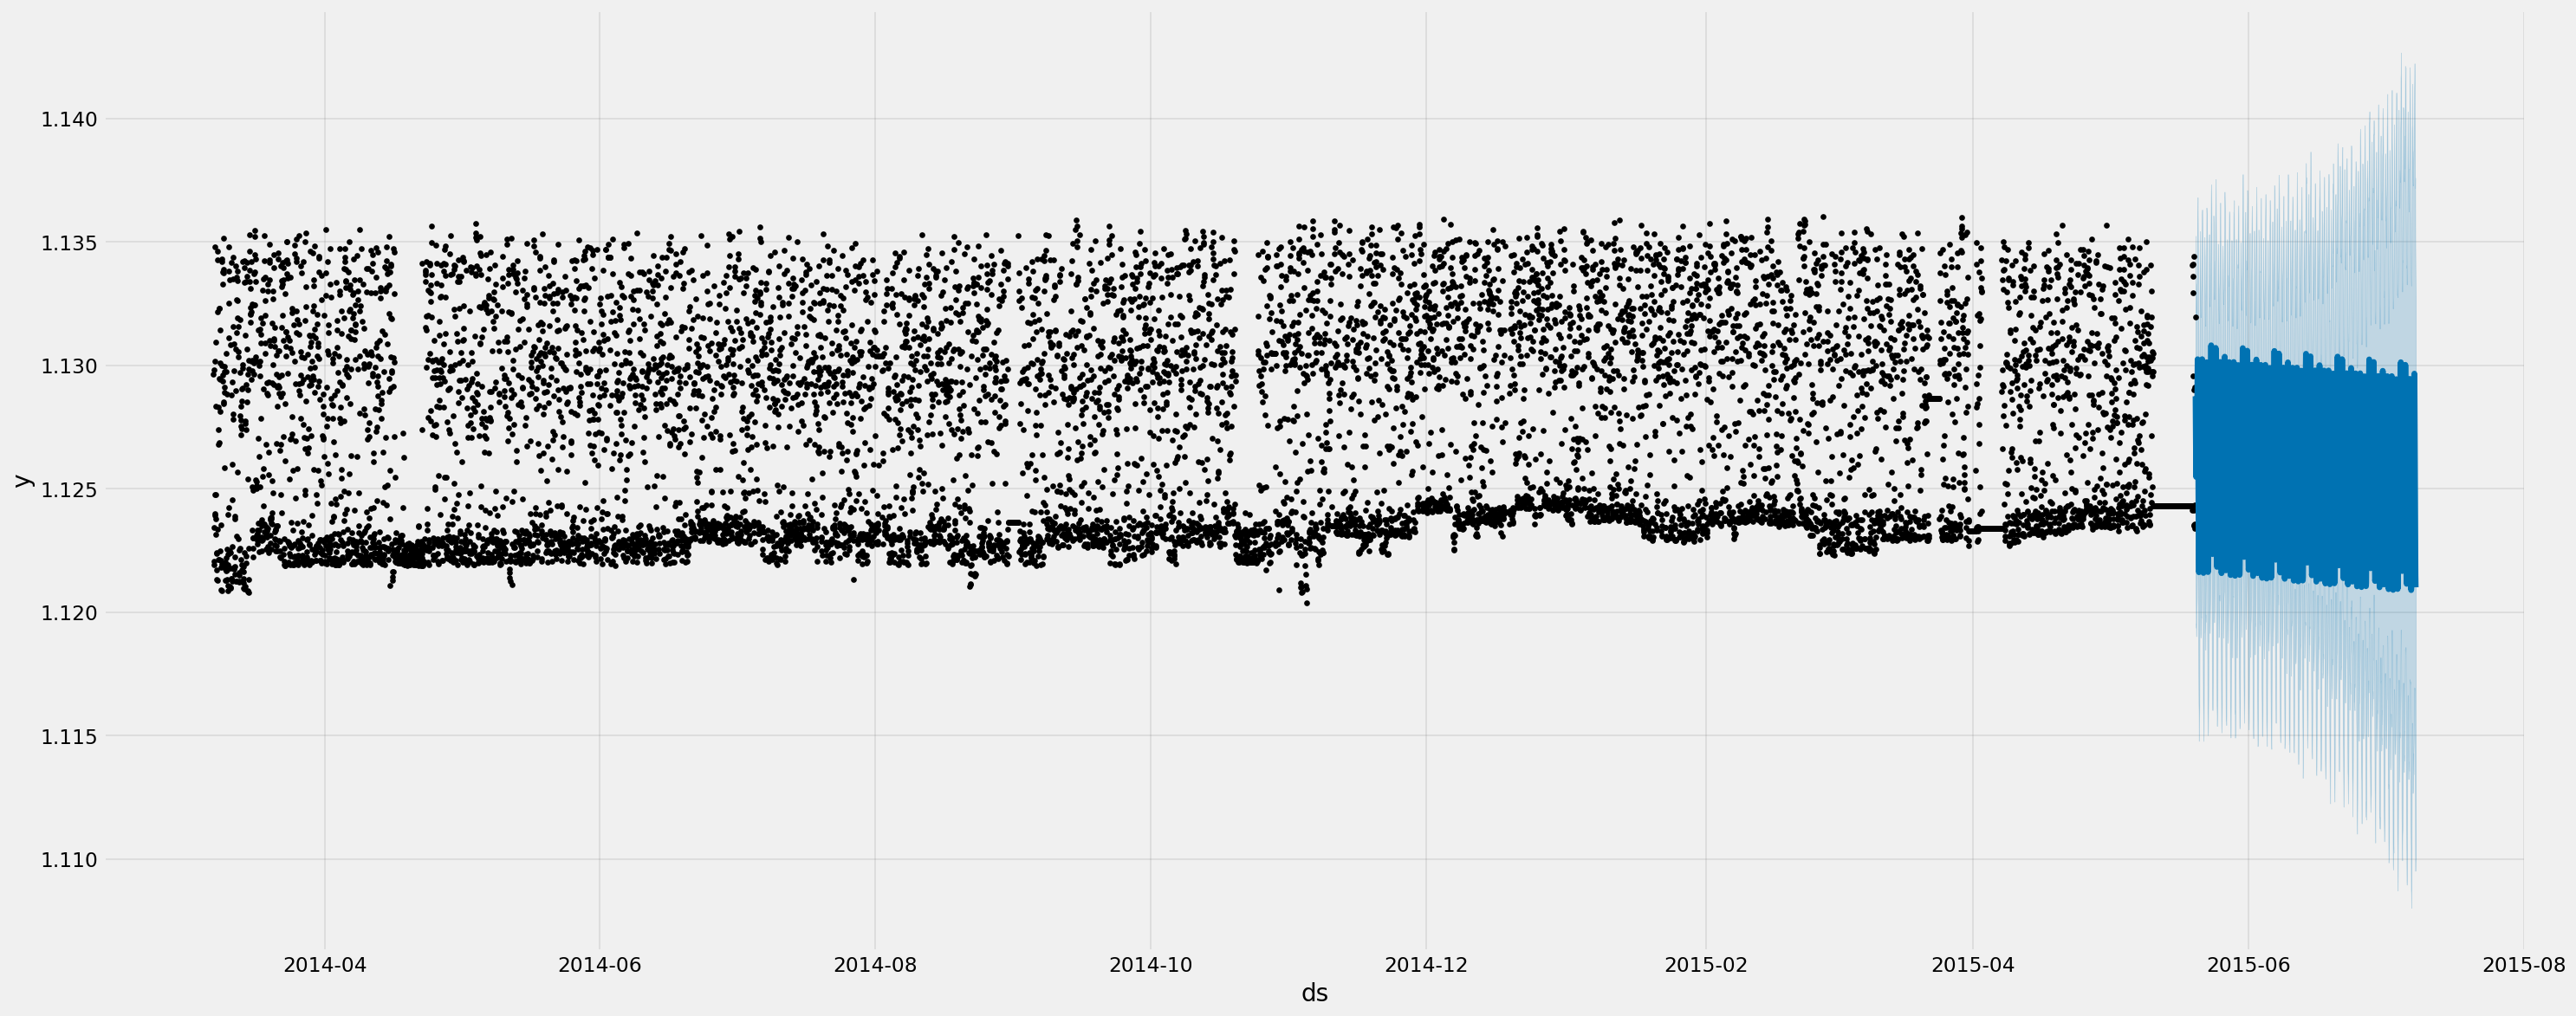

In [195]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(25)
fig = model.plot(prediction,
                 ax=ax)
plt.show()

In [196]:
type(prediction)

pandas.core.frame.DataFrame

<AxesSubplot:>

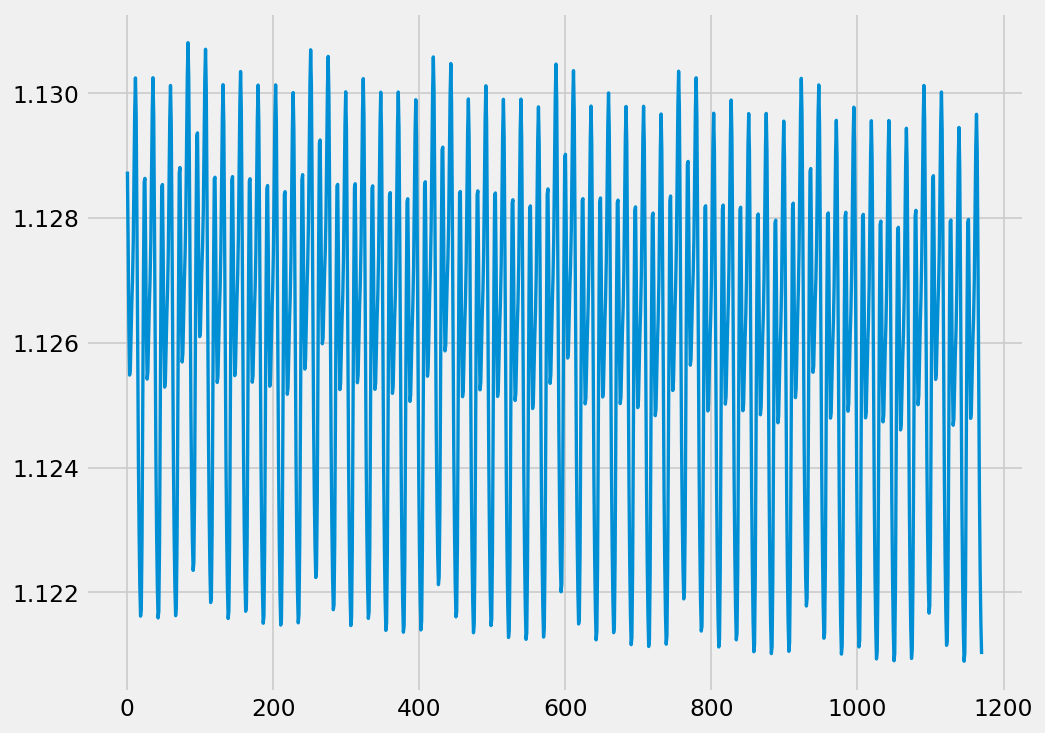

In [200]:
prediction['yhat'].plot(lw=2)